In [1]:
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import gzip
import re
import json

In [52]:
def parse_line(l):
    try:
        l = l.decode()
    except:
        print("Error on Line")
        print(l)
        return None
    if l[0] == '#': 
        return None
    if len(l) < 33:
        #print("ERROR: "+l)
        return None
    return {
        "task": re.sub("^ *", "", l[0:16]),
        "pid": int(re.sub(" +$", "", l[17:22])),
        "cpu": int(l[24:27]),
        "irq_off": l[29],
        "need_resched": l[30],
        "hardirq_softirq": l[31],
        "preempt_depth": int(l[32]),
        "timestamp": float(l[33:45]),
        "function": re.sub(":.*", "", l[48:])[:-1],
        "arguments": re.sub("[^:]+:", "", l[48:])[:-1]
    }

In [47]:
def load_log(tracefile):
    with gzip.open(tracefile) as f:
        return [
            line 
            for line in [parse_line(line) for line in f]
            if line != None
        ]

In [5]:
def query_state(trace):
    return [
        [line["timestamp"], 1 if re.match(".*(SQL_START|BDB_START|DELAY_end)", line["arguments"]) else 0, line["arguments"]]
        for line in trace
        if re.match(".*(DELAY_|SQL_|BDB_)", line["arguments"])
        and line["function"] == "tracing_mark_write"
        and line["task"] == "chmark_withjson"
    ]

In [6]:
def compute_deltas(trace):
    state_changes = query_state(trace)
    state_on = state_changes[0::2]
    state_off = state_changes[1::2]
    assert( len([x for x in state_on if x[1] != 1]) == 0)
    assert( len([x for x in state_off if x[1] != 0]) == 0)
    start_time = state_on[0][0]
    state_pairs = zip([x[0] for x in state_on], [x[0] for x in state_off])
    return [
        (x[0]-start_time, x[1]-x[0])
        for x in state_pairs
    ]

In [73]:
all_governors = ["conservative", "interactive", "ondemand", "performance", "powersave", "youtube_interactive", "youtube_ondemand", "userspace"]

In [8]:
def load_deltas(tracefile):
    print("Loading "+tracefile)
    return np.array(compute_deltas(load_log(tracefile)))

In [9]:
def load_ops(opsfile):
    with open(opsfile) as f:
        benchmark = json.load(f)["benchmark"]
        return zip(
            range(0, len(benchmark)),
            [
                ( x["sql"].split(" ")[0] )
                for x in benchmark
                if x["op"] == "query"
            ]
        )


In [10]:
def load_ops_by_category(opsfile):
    result = {}
    for idx, event in load_ops(opsfile):
        if event not in result:
            result[event] = []
        result[event] += [ (idx, len(result[event])) ]
    return result
    
# load_ops_by_category("../files/json/log_timing/workload_a_timing_a.json")

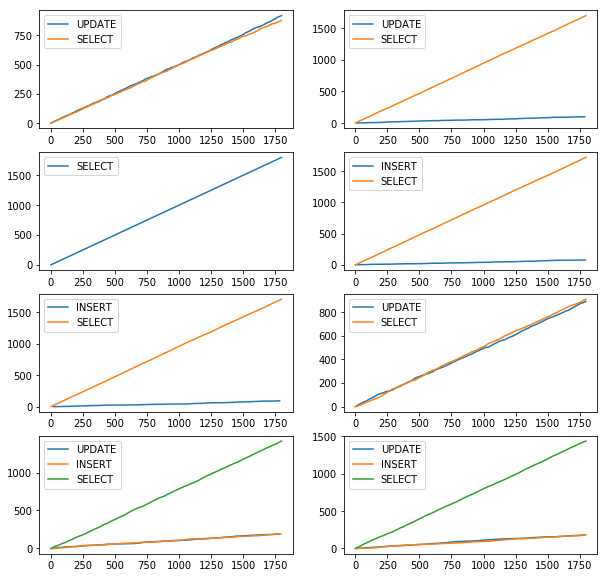

In [11]:
def plot_ops(opsfile, ax = None):
    if ax == None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ops = load_ops_by_category(opsfile)
    for event in ops:
        points = ops[event]
        scale = float(points[-1][1])
        ax.plot(
            [x[0] for x in points],
            [x[1] for x in points],
            label = event
        )
    ax.legend()

opsfiles = [
    "../files/json/log_timing/workload_"+x+"_timing_a.json"
    for x in ["a","b","c","d","e","f","ib","ic"]
]

fig = plt.figure(figsize = (10,10))
for i, opsfile in zip(range(0, len(opsfiles)), opsfiles):
    ax = fig.add_subplot(421+i)
    plot_ops(opsfile, ax)


In [12]:
def reduce(arr):
    result = {}
    for k, v in arr:
        if k not in result:
            result[k] = []
        result[k] += [v]
    return result

In [13]:
def label_deltas(deltas, opsfile):
    deltas = zip(load_ops(opsfile), deltas, range(0, len(deltas)))
    return reduce([
        (x[0][1], (x[2],x[1][1]))
        for x in deltas
    ])

In [15]:
all_workloads = [
    { "code" : "A", "source_code" : "A", "ops" : opsfiles[0] },  
    { "code" : "B", "source_code" : "B", "ops" : opsfiles[1] },  
    { "code" : "C", "source_code" : "C", "ops" : opsfiles[2] },  
    { "code" : "D", "source_code" : "D", "ops" : opsfiles[3] },  
    { "code" : "E", "source_code" : "E", "ops" : opsfiles[4] },  
    { "code" : "F", "source_code" : "F", "ops" : opsfiles[5] },  
    { "code" : "G", "source_code" : "IB", "ops" : opsfiles[6] },  
    { "code" : "H", "source_code" : "IC", "ops" : opsfiles[7] }
]

In [24]:
all_latencies = {}

In [68]:
for workload in all_workloads:
    code = workload["code"]
    if code not in all_latencies:
        all_latencies[code] = {
            "code" : workload["code"],
            "ops"  : workload["ops"]
        }
    for gov in all_governors:
        if gov not in all_latencies[code]:
            path = ""
            if gov.startswith("youtube_"):
                path = "../governor_traces/youtube_with/log_"+gov[8:]+"/YCSB_Workload"+workload["source_code"]+"_TimingAsql.log.gz"
            else:
                path = "../governor_traces/with_delaytags/log_"+gov+"/YCSB_Workload"+workload["source_code"]+"_TimingAsql.log.gz"
            all_latencies[code][gov] = load_deltas(path)


Loading ../governor_traces/youtube_with/log_ondemand/YCSB_WorkloadA_TimingAsql.log.gz
Loading ../governor_traces/youtube_with/log_ondemand/YCSB_WorkloadB_TimingAsql.log.gz
Loading ../governor_traces/youtube_with/log_ondemand/YCSB_WorkloadC_TimingAsql.log.gz
Error on Line
b'           <...>-5797  [001] ...2   489.585196: sched_switch: prev_comm=workqueue_truste\xa5\x16 prev_pid=5797 prev_prio=98 prev_state=D ==> next_comm=swapper/1 next_pid=0 next_prio=120\n'
Error on Line
b'           <...>-6376  [001] ...2   525.505570: sched_switch: prev_comm=workqueue_truste\xe8\x18 prev_pid=6376 prev_prio=98 prev_state=D ==> next_comm=chmark_withjson next_pid=5613 next_prio=130\n'
Loading ../governor_traces/youtube_with/log_ondemand/YCSB_WorkloadD_TimingAsql.log.gz
Error on Line
b'           <...>-4850  [001] ...2   311.385100: sched_switch: prev_comm=workqueue_truste\xf2\x12 prev_pid=4850 prev_prio=98 prev_state=D ==> next_comm=swapper/1 next_pid=0 next_prio=120\n'
Error on Line
b'           <...>

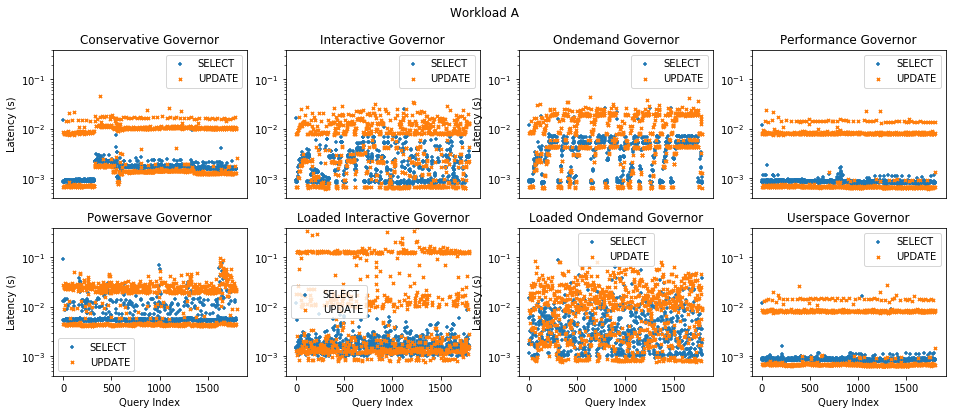

In [99]:
def plot_workload_latencies(latency_data):
    opsfile = latency_data["ops"]
    workload_title = "Workload "+latency_data["code"].upper()
    save_file = "workload_"+latency_data["code"].lower()+"_time_log_grid.pdf"
    fig = plt.figure( figsize = (16, 6) )
    for i in range(0,len(all_governors)):
        ax = fig.add_subplot(241+i)
        ax.semilogy()
        ax.set_ylim(4e-4,4e-1)
        if i >= 4:
            ax.set_xlabel("Query Index")
        else:
            ax.get_xaxis().set_visible(False)
        if i % 2 == 0:
            ax.set_ylabel("Latency (s)")
        title = all_governors[i].replace("youtube_", "Loaded ").title()+" Governor"
        ax.set_title(title)
        labeled_deltas = label_deltas(latency_data[all_governors[i]], opsfile)
        for q in ["SELECT", "UPDATE", "INSERT"]:
            if q in labeled_deltas:
                ax.scatter(
                    [x[0] for x in labeled_deltas[q]],
                    [x[1] for x in labeled_deltas[q]],
                    s=10, label = q, marker = ('+' if q == "SELECT" else 'x')
                )
        ax.legend()
    fig.suptitle(workload_title)
    fig.savefig(save_file, bbox_inches='tight')
plot_workload_latencies(all_latencies["A"])

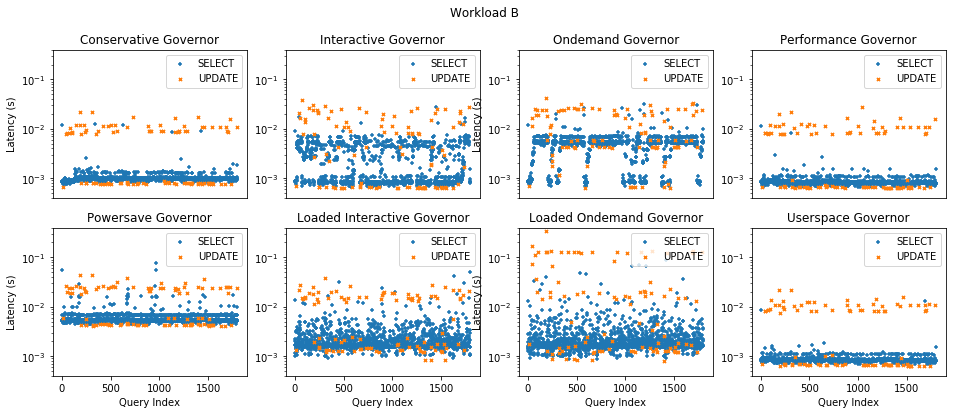

In [100]:
plot_workload_latencies(all_latencies["B"])

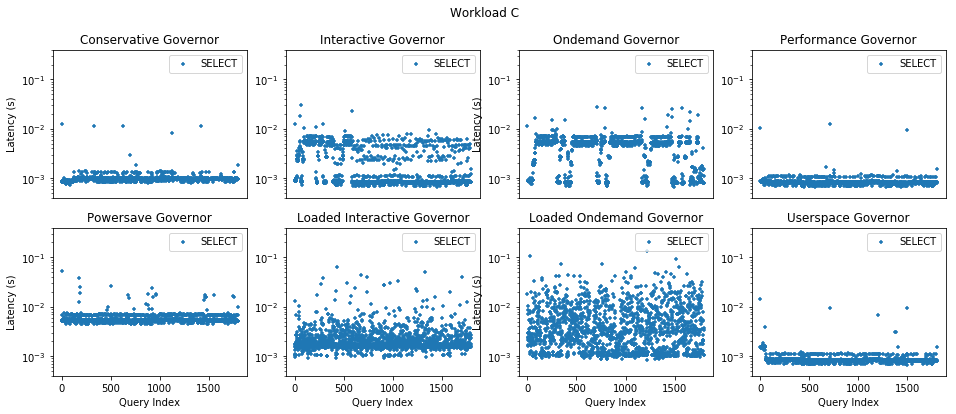

In [101]:
plot_workload_latencies(all_latencies["C"])

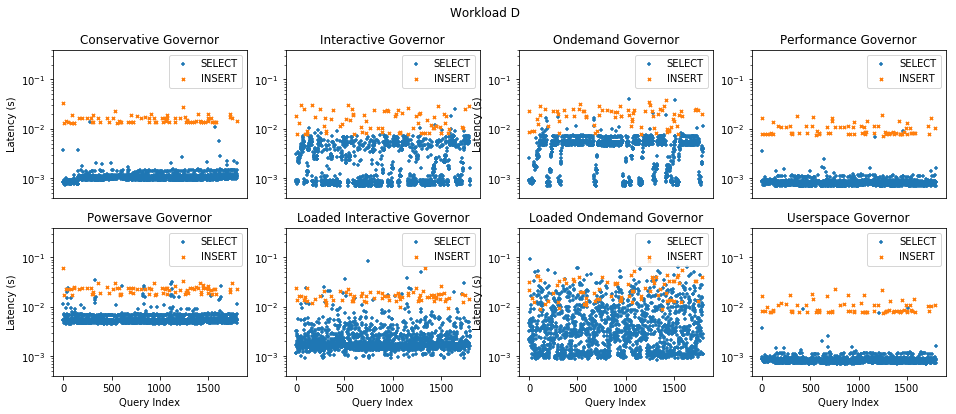

In [102]:
plot_workload_latencies(all_latencies["D"])

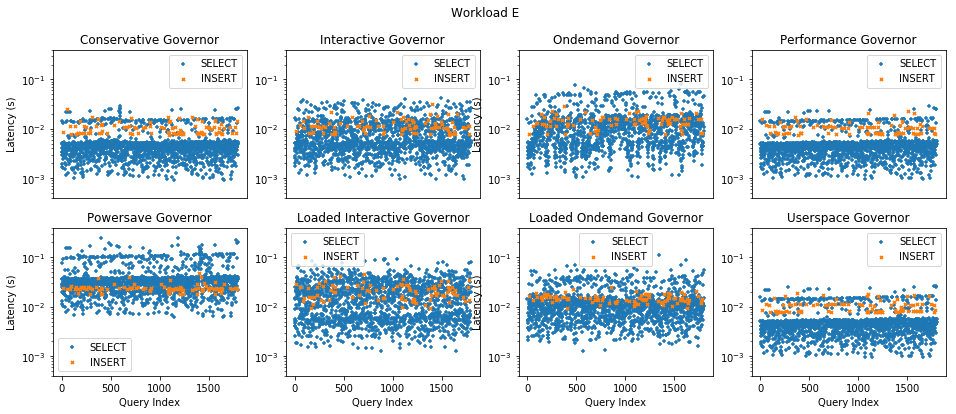

In [103]:
plot_workload_latencies(all_latencies["E"])

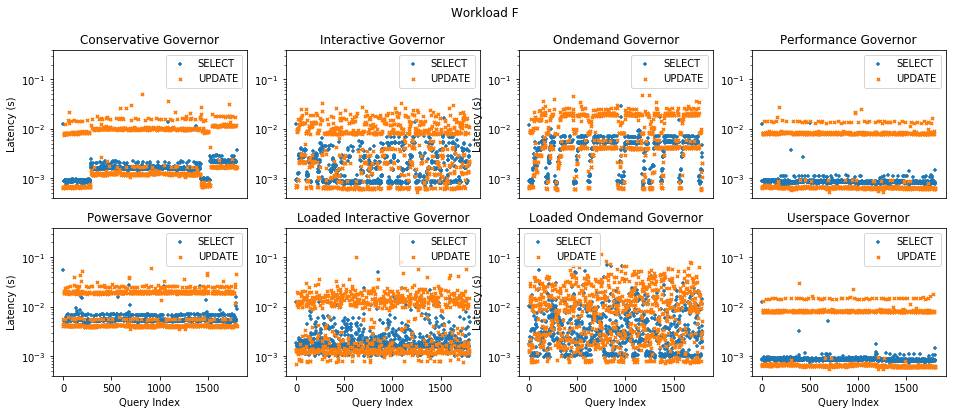

In [104]:
plot_workload_latencies(all_latencies["F"])

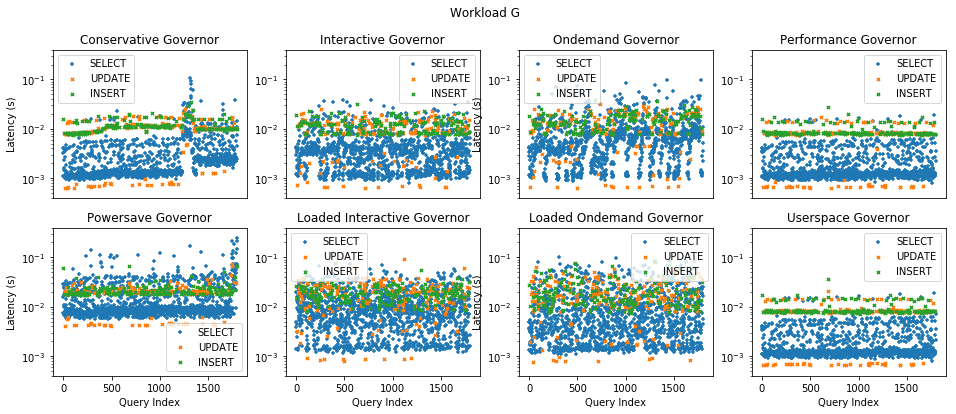

In [105]:
plot_workload_latencies(all_latencies["G"])

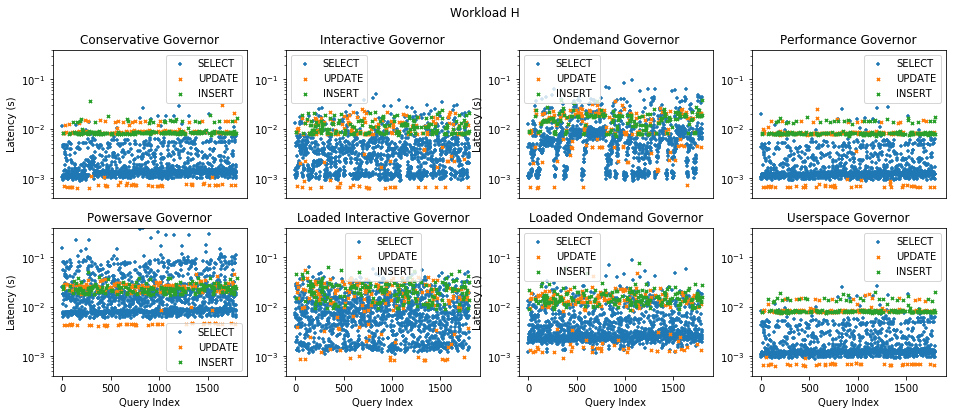

In [106]:
plot_workload_latencies(all_latencies["H"])

workload_a_time_log_hist.pdf
workload_b_time_log_hist.pdf
workload_c_time_log_hist.pdf
workload_d_time_log_hist.pdf
workload_e_time_log_hist.pdf
workload_f_time_log_hist.pdf
workload_g_time_log_hist.pdf
workload_h_time_log_hist.pdf


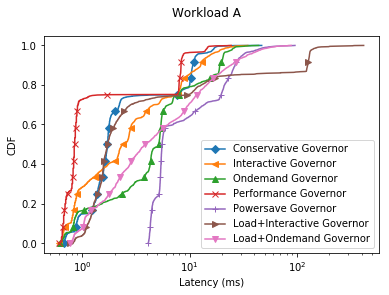

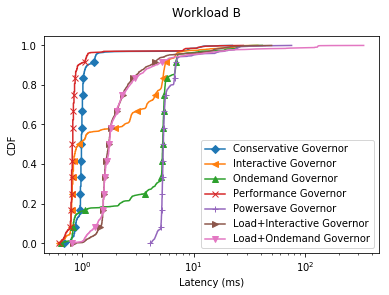

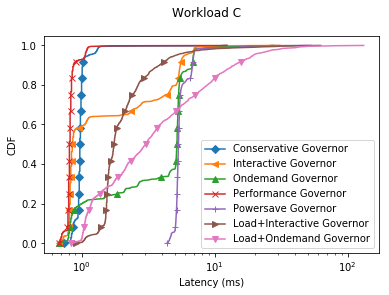

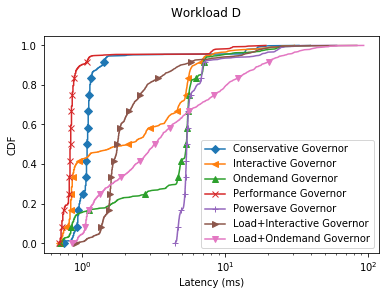

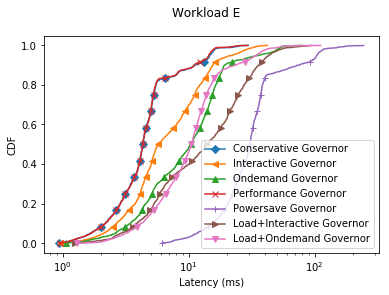

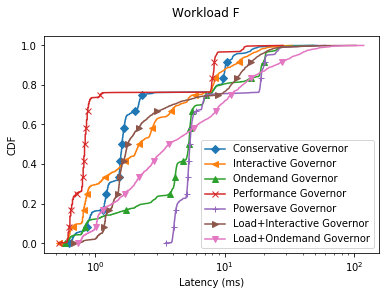

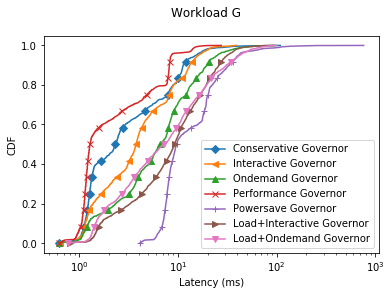

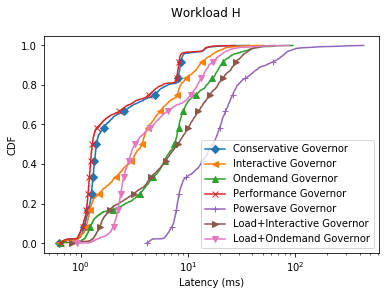

In [98]:
def plot_joint_workload_delta_histogram(latency_data):
    fig = plt.figure( figsize = (6, 4) )
    ax = fig.add_subplot(111)
    ax.semilogx()
    ax.set_xlabel("Latency (ms)")
    ax.set_ylabel("CDF")
    markers = 'D<^x+>v1'
    for i in range(0,len(all_governors)):
        if(all_governors[i] != "userspace"):
            curr_deltas = latency_data[all_governors[i]]
            title = all_governors[i].replace("youtube_", "Load+").title()+" Governor"
            num_deltas = float(len(curr_deltas))
            ax.plot(
                sorted([x[1]*1000 for x in curr_deltas]),
                [x / num_deltas for x in range(0, len(curr_deltas))],
                marker=markers[i],
                markevery = 150,
                label = title
            )
    ax.legend()
    fig.suptitle("Workload "+latency_data["code"].upper())
    fig.savefig("workload_"+latency_data["code"].lower()+"_time_log_joint_hist.pdf", bbox_inches='tight')

all_codes = "ABCDEFGH"
for code in all_codes:
    print("workload_"+code.lower()+"_time_log_hist.pdf")
    plot_joint_workload_delta_histogram(all_latencies[code])

In [67]:
def plot_workload_delta_histogram(deltas, opsfile, workload_title, save_file = None):
    fig = plt.figure( figsize = (12, 8) )
    for i in range(0,6):
        ax = fig.add_subplot(321+i)
        ax.loglog()
        if i >= 4:
            ax.set_xlabel("Latency (s)")
        else:
            ax.get_xaxis().set_visible(False)
        if i % 2 == 0:
            ax.set_ylabel("Count")
        title = all_governors[i].title()+" Governor"
        ax.set_title(title)
        labeled_deltas = label_deltas(deltas[i], opsfile)
        for q in labeled_deltas:
            ax.hist(
                [x[1] for x in labeled_deltas[q]],
                log = True,
                bins = 100,
                histtype = "step",
                label = q
            )
        ax.legend()
    fig.suptitle(workload_title)
    if save_file != None:
        fig.savefig(save_file, bbox_inches='tight')